In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.metrics import roc_curve, auc

fig_dir = './figs/'

df_all = pd.read_csv('paper-figure_celllist_all.csv')

facilities = {
    '1_CIH': 'C',
    '2_Tsukuba': 'T',
    '3_Kaetsu': 'K',
    '4_Junten': 'J' 
}

custom_stack_order = ['Squ.epi', 'Squ.meta', 'Navicular', 'Para.Squ', 'Para.Clust', 'Glan', 'Leu','Debris', 'LSIL', 'HSIL', 'Adenocarcinoma']

probability_threshold = 0.8
for param in custom_stack_order:
    df_all[param] = df_all[f'class_count-{probability_threshold}'].apply(ast.literal_eval).apply(lambda x: x.get(param, 0))


In [2]:

"""
# ROC curves for detecting cytological abnormalities using LSIL and HSIL cell counts

Receiver Operating Characteristic (ROC) curves illustrating the diagnostic performance of LSIL and HSIL cell count-based indices. 
The orange line shows the performance of a combined LSIL + HSIL count metric for detecting low-grade or higher abnormalities 
(LSIL, ASC-H, HSIL, or SCC) among HPV-positive specimens. The red line represents the performance of HSIL count alone for 
detecting high-grade abnormalities (HSIL or SCC). The area under the curve (AUC) is shown for each model. 
These results demonstrate the relative effectiveness of cytological metrics in stratifying disease severity among HPV-positive cases.
"""

def draw_roc_cytology(df, title='', savefilename=''):
    # ---------- LSIL+ ----------
    df_temp = df.query('Class != "ASC-US"').copy()
    df_temp['label_lsil'] = df_temp['Class'].isin(['LSIL', 'ASC-H', 'HSIL', 'SCC']).astype(int)
    df_temp['score_lsil'] = df_temp['LSIL'] + df_temp['HSIL']
    print(f'LSIL+ samples: {df_temp["label_lsil"].sum()} / {df_temp.shape[0]}')
    fpr_lsil, tpr_lsil, _ = roc_curve(df_temp['label_lsil'], df_temp['score_lsil'])
    auc_lsil = auc(fpr_lsil, tpr_lsil)

    # ---------- HSIL+ ----------
    df_temp = df.query('Class != "ASC-H"').copy()
    df_temp['label_hsil'] = df_temp['Class'].isin(['HSIL', 'SCC']).astype(int)
    df_temp['score_hsil'] = df_temp['HSIL']
    print(f'HSIL+ samples: {df_temp["label_hsil"].sum()} / {df_temp.shape[0]}')
    fpr_hsil, tpr_hsil, _ = roc_curve(df_temp['label_hsil'], df_temp['score_hsil'])
    auc_hsil = auc(fpr_hsil, tpr_hsil)

    # ---------- Plot ----------
    plt.figure(figsize=(4, 4))

    # LSIL+ : Orange
    plt.plot(fpr_lsil, tpr_lsil, color='orange', lw=2,
            label=f'LSIL+ (AUC = {auc_lsil:.2f})')

    # HSIL+ : Red
    plt.plot(fpr_hsil, tpr_hsil, color='red', lw=2,
            label=f'HSIL+ (AUC = {auc_hsil:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlabel("False positive rate", fontsize=16)
    plt.ylabel("True positive rate", fontsize=16)
    plt.title(title, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.margins(x=0.01, y=0.01)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.grid(False)
    plt.tight_layout()
    if savefilename != '':
        plt.savefig(savefilename, bbox_inches='tight')
    plt.show()


LSIL+ samples: 427 / 785
HSIL+ samples: 185 / 1097


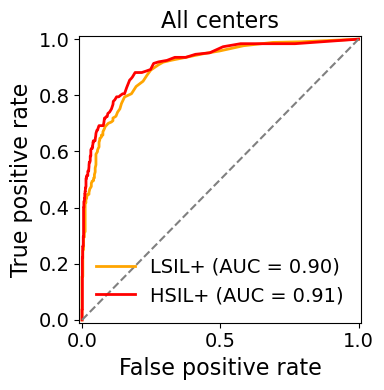

In [3]:
draw_roc_cytology(df_all, title=f'All centers', savefilename=f'{fig_dir}fig7e_roc_all_centers.svg')

--------------- Facility: 1_CIH (N = 318) ---------------
LSIL+ samples: 77 / 246
HSIL+ samples: 26 / 309


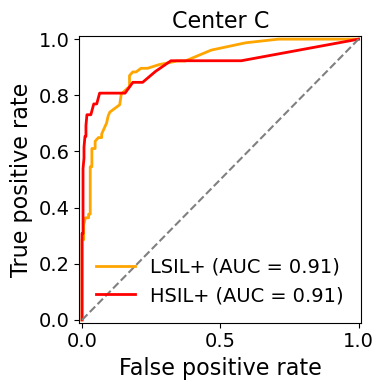

--------------- Facility: 2_Tsukuba (N = 222) ---------------
LSIL+ samples: 136 / 191
HSIL+ samples: 65 / 205


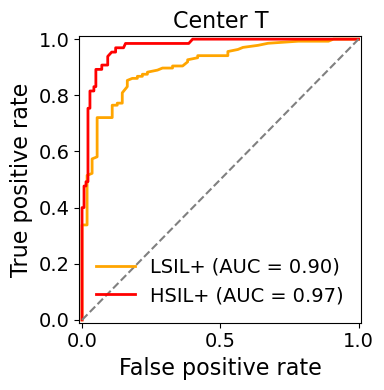

--------------- Facility: 3_Kaetsu (N = 385) ---------------
LSIL+ samples: 89 / 174
HSIL+ samples: 19 / 384


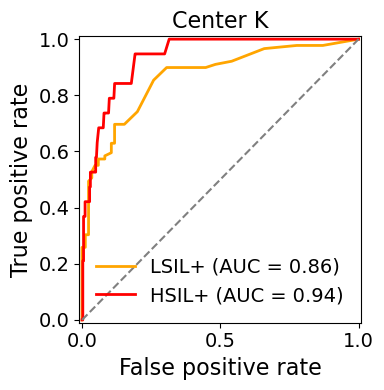

--------------- Facility: 4_Junten (N = 199) ---------------
LSIL+ samples: 125 / 174
HSIL+ samples: 75 / 199


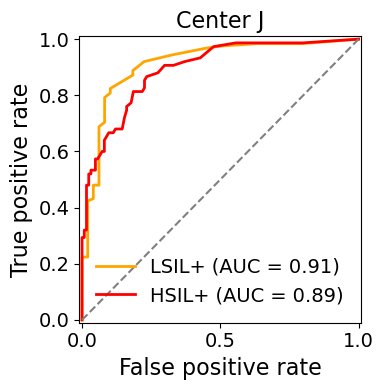

In [4]:

for facility, label in facilities.items():
    df_temp = df_all.query(f'Facility == "{facility}"')
    print(f'--------------- Facility: {facility} (N = {len(df_temp)}) ---------------')
    draw_roc_cytology(df_temp, title=f'Center {label}', savefilename=f'{fig_dir}fig7e_roc_{facility}.svg')

In [5]:
df_all['SlideType'].value_counts()

SlideType
BD          1071
Thinprep      53
Name: count, dtype: int64

Facility: 1_CIH, SlideType: BD (N = 265)
LSIL+ samples: 53 / 194
HSIL+ samples: 12 / 259


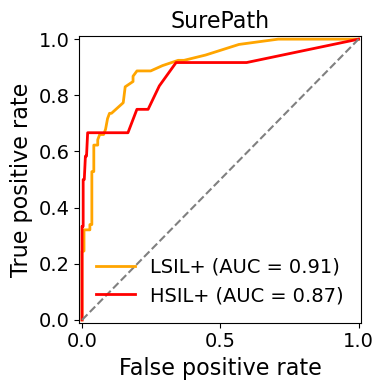

Facility: 1_CIH, SlideType: ThinPrep (N = 53)
LSIL+ samples: 24 / 52
HSIL+ samples: 14 / 50


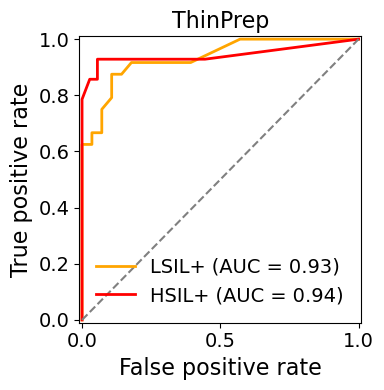

In [6]:
facility = '1_CIH'
df_temp2 = df_all.query(f'Facility == "{facility}" and SlideType=="BD"')
print(f'Facility: {facility}, SlideType: BD (N = {len(df_temp2)})')
draw_roc_cytology(df_temp2, savefilename=f'{fig_dir}/Efig12b_roc_{facilities[facility]}_BD.svg', title='SurePath')

df_temp2 = df_all.query(f'Facility == "{facility}" and SlideType in ["ThinPrep", "Thinprep"]')
print(f'Facility: {facility}, SlideType: ThinPrep (N = {len(df_temp2)})')
draw_roc_cytology(df_temp2, savefilename=f'{fig_dir}/Efig12c_roc_{facilities[facility]}_ThinPrep.svg', title='ThinPrep')


In [7]:
# ==== ROC ====
def calc_roc(true_label, target_label, n_boot=2000, seed=42, grid_points=101, silent=False):

    y_true = np.asarray(true_label).astype(int)
    y_score = np.asarray(target_label).astype(float)    

    fpr, tpr, thr = roc_curve(y_true, y_score, pos_label=1)
    aucval = auc(fpr, tpr)

    # ====== ROC confidence interval - bootstrap (stratified) ======
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    n_pos, n_neg = pos_idx.size, neg_idx.size

    fpr_grid = np.linspace(0, 1, grid_points)
    auc_bs = np.empty(n_boot)
    tpr_band = np.empty((n_boot, fpr_grid.size))

    for b in range(n_boot):
        # layered stratified resampling
        pos_s = rng.choice(pos_idx, size=n_pos, replace=True)
        neg_s = rng.choice(neg_idx, size=n_neg, replace=True)
        idx_s = np.r_[pos_s, neg_s]

        yb = y_true[idx_s]
        sb = y_score[idx_s]

        fpr_b, tpr_b, _ = roc_curve(yb, sb, pos_label=1)
        auc_b = auc(fpr_b, tpr_b)
        auc_bs[b] = auc_b

        # Interpolate TPR to common grid (fixing ends)
        tpr_band[b] = np.interp(fpr_grid, fpr_b, tpr_b, left=0.0, right=1.0)

    def perc_ci(x, alpha=0.05):
        lo = np.nanpercentile(x, 100*(alpha/2))
        hi = np.nanpercentile(x, 100*(1-alpha/2))
        return lo, hi

    auc_lo, auc_hi = perc_ci(auc_bs, 0.05)
    tpr_lo = np.nanpercentile(tpr_band, 2.5, axis=0)
    tpr_hi = np.nanpercentile(tpr_band, 97.5, axis=0)

    if not silent:
        print(f"AUC: {aucval:.3f} (95%CI {auc_lo:.3f}-{auc_hi:.3f})")

    return fpr, tpr, fpr_grid, tpr_lo, tpr_hi, aucval, auc_lo, auc_hi


auc_lsil_facility = []
auc_hsil_facility = []
for prob_thresh100 in range(60, 100, 1):
    prob_thresh = prob_thresh100 / 100
    df_all['LSIL_count'] = [a['LSIL'] for a in df_all[f'class_count-{prob_thresh}'].apply(ast.literal_eval)]
    df_all['HSIL_count'] = [a['HSIL'] for a in df_all[f'class_count-{prob_thresh}'].apply(ast.literal_eval)]
    
    for facility in facilities.keys():

        try:
            df_facility = df_all[df_all['Facility'] == facility]

            df_temp = df_facility.query('Class != "ASC-US"')
            true_label = (df_temp['Class'].isin(["LSIL", "ASC-H", "HSIL", "SCC"])).astype(int)
            target_label = df_temp["LSIL_count"] + df_temp["HSIL_count"]
            fpr, tpr, fpr_grid, tpr_lo, tpr_hi, aucval, auc_lo, auc_hi = calc_roc(true_label, target_label, silent=True)
            auc_lsil_facility.append({
                'prob_thresh': prob_thresh,
                'facility': facility,
                'aucval': aucval,
                'auc_lo': auc_lo,
                'auc_hi': auc_hi
            })

            df_temp = df_facility.query('Class != "ASC-H"')
            true_label = (df_temp['Class'].isin(["HSIL", "SCC"])).astype(int)
            target_label = df_temp["HSIL_count"]
            fpr, tpr, fpr_grid, tpr_lo, tpr_hi, aucval, auc_lo, auc_hi = calc_roc(true_label, target_label, silent=True)
            auc_hsil_facility.append({
                'prob_thresh': prob_thresh,
                'facility': facility,
                'aucval': aucval,
                'auc_lo': auc_lo,
                'auc_hi': auc_hi
            })
        except:
            continue

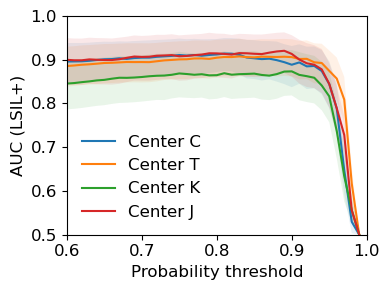

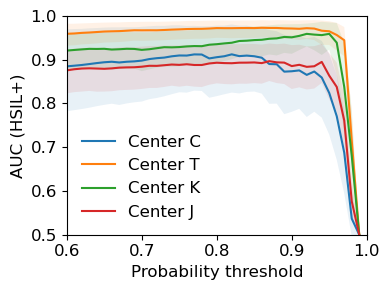

In [8]:
df_auc_lsil_facility = pd.DataFrame(auc_lsil_facility)
df_auc_hsil_facility = pd.DataFrame(auc_hsil_facility)

plt.figure(figsize=(4,3))
for facility in facilities.keys():
    df_tmp = df_auc_lsil_facility[df_auc_lsil_facility['facility'] == facility]
    plt.plot(df_tmp['prob_thresh'], df_tmp['aucval'], label=f'Center {facilities[facility]}')
    plt.fill_between(df_tmp['prob_thresh'], df_tmp['auc_lo'], df_tmp['auc_hi'], alpha=0.1)
plt.xlabel('Probability threshold', fontsize=12)
plt.ylabel('AUC (LSIL+)', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.xlim(0.6,1)
plt.ylim(0.5,1.0)
plt.legend(loc='lower left', ncols=1, fontsize=12, frameon=False)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig7f_Thresh-AUC-LSIL.svg', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,3))
for facility in facilities.keys():
    df_tmp = df_auc_hsil_facility[df_auc_hsil_facility['facility'] == facility]
    plt.plot(df_tmp['prob_thresh'], df_tmp['aucval'], label=f'Center {facilities[facility]}')
    plt.fill_between(df_tmp['prob_thresh'], df_tmp['auc_lo'], df_tmp['auc_hi'], alpha=0.1)
plt.xlabel('Probability threshold', fontsize=12)
plt.ylabel('AUC (HSIL+)', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.xlim(0.6,1)
plt.ylim(0.5,1.0)
plt.legend(loc='lower left', ncols=1, fontsize=12, frameon=False)
plt.tight_layout()
plt.savefig(f'{fig_dir}/fig7g_Thresh-AUC-HSIL.svg', bbox_inches='tight')
plt.show()